In [1]:
import mariadb
import sys
import pandas as pd
import matplotlib as plt
import numpy as np
%matplotlib inline

In [2]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
#set_matplotlib_formats('svg')
plt.rcParams['figure.figsize'] = [3, 3]

In [3]:
# Connect to MariaDB Platform
try:
    conn = mariadb.connect(
        user="root",
        password="admin",
        host="127.0.0.1",
        port=3303,
        database="ks"

    )
except mariadb.Error as e:
    print(f"Error connecting to MariaDB Platform: {e}")
    sys.exit(1)

# Get Cursor
cur = conn.cursor()

# Assumptions & notes: Currency conversion is only performed in country comparison, everywhere else only data from USD denominated campaigns is used or currency is ignored.

## Are the goals for dollars raised significantly different between campaigns that are successful and unsuccessful?

In [4]:
goals = pd.read_sql("SELECT AVG(goal) as average_goal,outcome FROM campaign JOIN currency ON currency.id=currency_id WHERE currency.name='USD' GROUP BY outcome;", conn).sort_values("average_goal")

<AxesSubplot:title={'center':'Goal vs Outcome'}, xlabel='Outcome', ylabel='Goal (logarithmic)'>

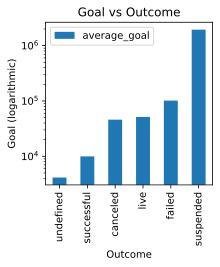

In [5]:
goals.plot(x="outcome", y="average_goal", kind="bar", title="Goal vs Outcome", logy=True, ylabel="Goal (logarithmic)", xlabel="Outcome")

In [6]:
pd.read_sql("SELECT AVG(goal) as average_goal,AVG(pledged) as average_pledged FROM campaign JOIN currency ON currency.id=currency_id WHERE currency.name='USD' and outcome='successful';", conn)

,average_goal,average_pledged
0,9975.664589,23117.091222


In [7]:
df_pl_g = pd.read_sql(
    "SELECT goal,pledged FROM campaign JOIN currency ON currency.id=currency_id WHERE currency.name='USD' and outcome='successful';"
    , conn)

In [8]:
outlier_gone = df_pl_g[np.abs(df_pl_g.goal-df_pl_g.goal.mean()) <= (3*df_pl_g.goal.std())]
outlier_gone = outlier_gone[np.abs(outlier_gone.pledged-outlier_gone.pledged.mean()) <= (3*outlier_gone.pledged.std())]

<AxesSubplot:xlabel='goal', ylabel='pledged'>

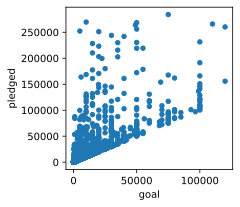

In [9]:
outlier_gone.plot(x="goal",y="pledged", kind="scatter")

Yes, the failed campaign average goal is 10x that of successful campaigns. The average goal of a successful campaign is a mere $9,975 dollars. Clearly, the lower the goal, the more likel it is to be reached, but it is also clear that as the goal becomes more ambitious, there is a higher chance that the actual amount pledged far exceeds the goal. There is a strong selection bias here as we are only looking at **successful** campaigns.

## Now let's look at board games specifically

In [10]:
goals = pd.read_sql("SELECT AVG(goal) as average_goal,outcome FROM campaign JOIN sub_category ON sub_category_id=sub_category.id JOIN category ON sub_category.category_id=category.id JOIN currency ON currency.id=currency_id WHERE currency.name='USD' and sub_category.name='Tabletop Games' GROUP BY outcome;", conn).sort_values("average_goal")

<AxesSubplot:title={'center':'Goal vs Outcome'}, xlabel='Outcome', ylabel='Goal'>

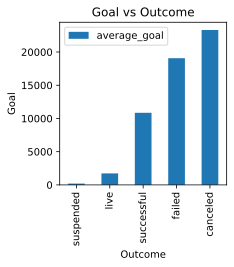

In [11]:
goals.plot(x="outcome", y="average_goal", kind="bar", title="Goal vs Outcome", logy=False, ylabel="Goal", xlabel="Outcome")

In [12]:
pd.read_sql("SELECT AVG(goal) as average_goal,AVG(pledged) as average_pledged,AVG(backers) as average_backers FROM campaign JOIN sub_category ON sub_category_id=sub_category.id JOIN category ON sub_category.category_id=category.id JOIN currency ON currency.id=currency_id WHERE currency.name='USD' and outcome='successful' and sub_category.name='Tabletop Games';", conn)


,average_goal,average_pledged,average_backers
0,10853.303571,67519.443348,901.567


Surprisingly, the average board game backer is dishing out $75.

In [13]:
df_pl_g = pd.read_sql(
    "SELECT goal,pledged FROM campaign JOIN sub_category ON sub_category_id=sub_category.id JOIN category ON sub_category.category_id=category.id JOIN currency ON currency.id=currency_id WHERE currency.name='USD' and outcome='successful' and sub_category.name='Tabletop Games';"
    , conn)

In [14]:
outlier_gone = df_pl_g[np.abs(df_pl_g.goal-df_pl_g.goal.mean()) <= (3*df_pl_g.goal.std())]
outlier_gone = outlier_gone[np.abs(outlier_gone.pledged-outlier_gone.pledged.mean()) <= (3*outlier_gone.pledged.std())]

<AxesSubplot:xlabel='goal', ylabel='pledged'>

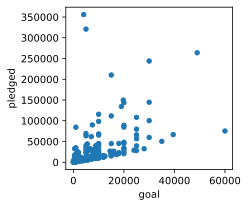

In [15]:
outlier_gone.plot(x="goal",y="pledged", kind="scatter")

In [16]:
df_pl_g = pd.read_sql(
    "SELECT goal,(pledged/backers) as avg_backer FROM campaign JOIN sub_category ON sub_category_id=sub_category.id JOIN category ON sub_category.category_id=category.id JOIN currency ON currency.id=currency_id WHERE currency.name='USD' and outcome='successful' and sub_category.name='Tabletop Games';"
    , conn)

In [17]:
outlier_gone = df_pl_g[np.abs(df_pl_g.goal-df_pl_g.goal.mean()) <= (3*df_pl_g.goal.std())]
outlier_gone = outlier_gone[np.abs(outlier_gone.avg_backer-outlier_gone.avg_backer.mean()) <= (3*outlier_gone.avg_backer.std())]


<AxesSubplot:xlabel='goal', ylabel='Average amount pledged per backer'>

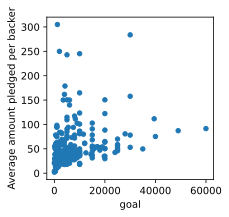

In [18]:
outlier_gone.plot(x="goal",y="avg_backer", ylabel="Average amount pledged per backer", kind="scatter")

In [19]:
backers_name = pd.read_sql(
    "SELECT goal,backers FROM campaign JOIN sub_category ON sub_category_id=sub_category.id JOIN category ON sub_category.category_id=category.id JOIN currency ON currency.id=currency_id WHERE currency.name='USD' and outcome='successful' and sub_category.name='Tabletop Games' and backers<40000 and goal<30000;"
    , conn)


<AxesSubplot:title={'center':'Goal vs no. backers (outliers excluded)'}, xlabel='goal', ylabel='backers'>

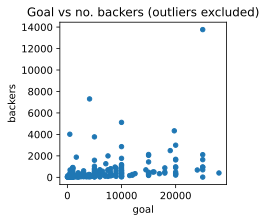

In [20]:
backers_name.plot(x="goal",y="backers", title="Goal vs no. backers (outliers excluded)", kind="scatter")

## What are the top/bottom 3 categories with the most backers? What are the top/bottom 3 subcategories by backers?

In [21]:
top_cat = pd.read_sql("SELECT SUM(backers) as sum_backers,category.name as category_name FROM campaign JOIN sub_category ON sub_category_id=sub_category.id JOIN category ON sub_category.category_id=category.id GROUP BY category_id ORDER BY sum_backers DESC LIMIT 3;", conn)

<AxesSubplot:title={'center':'No. of backers vs Category'}>

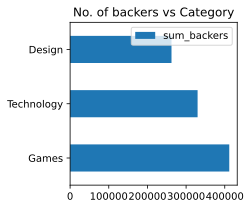

In [22]:
top_cat.plot(x="category_name", y="sum_backers", kind="barh", title="No. of backers vs Category", ylabel="No. of backers", xlabel="")

In [23]:
bot_cat = pd.read_sql("SELECT SUM(backers) as sum_backers,category.name as category_name FROM campaign JOIN sub_category ON sub_category_id=sub_category.id JOIN category ON sub_category.category_id=category.id GROUP BY category_id ORDER BY sum_backers ASC LIMIT 3;", conn)

<AxesSubplot:title={'center':'No. of backers vs Category'}>

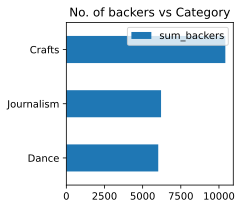

In [24]:
bot_cat.plot(x="category_name", y="sum_backers", kind="barh", title="No. of backers vs Category", ylabel="No. of backers", xlabel="")

In [25]:
top_subcat = pd.read_sql("SELECT SUM(backers) as sum_backers,sub_category.name as subcategory_name FROM campaign JOIN sub_category ON sub_category_id=sub_category.id JOIN category ON sub_category.category_id=category.id GROUP BY sub_category.id ORDER BY sum_backers DESC LIMIT 3;", conn)

<AxesSubplot:title={'center':'No. of backers vs Sub-category'}>

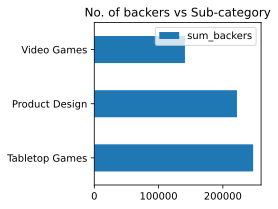

In [26]:
top_subcat.plot(x="subcategory_name", y="sum_backers", kind="barh", title="No. of backers vs Sub-category", ylabel="No. of backers", xlabel="")

In [27]:
bot_subcat = pd.read_sql("SELECT SUM(backers) as sum_backers,sub_category.name as subcategory_name FROM campaign JOIN sub_category ON sub_category_id=sub_category.id JOIN category ON sub_category.category_id=category.id GROUP BY sub_category.id ORDER BY sum_backers ASC LIMIT 3;", conn)

<AxesSubplot:title={'center':'No. of backers vs Sub-category'}>

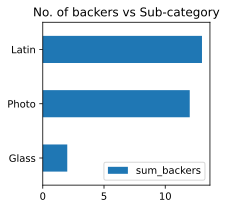

In [28]:
bot_subcat.plot(x="subcategory_name", y="sum_backers", kind="barh", title="No. of backers vs Sub-category", ylabel="No. of backers", xlabel="")

## What are the top/bottom 3 categories that have raised the most money? What are the top/bottom 3 subcategories that have raised the most money?

In [29]:
top_pledge_cat = pd.read_sql("SELECT SUM(pledged) as sum_backers,category.name as category_name FROM campaign JOIN currency ON currency.id=currency_id JOIN sub_category ON sub_category_id=sub_category.id JOIN category ON sub_category.category_id=category.id WHERE currency.name='USD' GROUP BY category_id ORDER BY sum_backers DESC LIMIT 3;", conn)



<AxesSubplot:title={'center':'Sum pledged by Category'}>

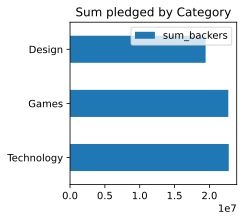

In [30]:
top_pledge_cat.plot(x="category_name", y="sum_backers", kind="barh", title="Sum pledged by Category", ylabel="Dollars (USD)", xlabel="")


In [31]:
bot_pledge_cat = pd.read_sql("SELECT SUM(pledged) as sum_backers,category.name as category_name FROM campaign JOIN currency ON currency.id=currency_id JOIN sub_category ON sub_category_id=sub_category.id JOIN category ON sub_category.category_id=category.id WHERE currency.name='USD' GROUP BY category_id ORDER BY sum_backers ASC LIMIT 3;", conn)



<AxesSubplot:title={'center':'Lowest sums pledged by Category'}>

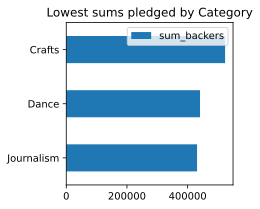

In [32]:
bot_pledge_cat.plot(x="category_name", y="sum_backers", kind="barh", title="Lowest sums pledged by Category", ylabel="Dollars (USD)", xlabel="")


### Here we will assume that subcategories are referring to the overall sub, not the subcategories of the most/least successful categories.

In [33]:
top_pledge_subcat = pd.read_sql("SELECT SUM(pledged) as sum_backers,sub_category.name as sub_category_name,sub_category.id FROM campaign JOIN currency ON currency.id=currency_id JOIN sub_category ON sub_category_id=sub_category.id JOIN category ON sub_category.category_id=category.id WHERE currency.name='USD' GROUP BY sub_category.id ORDER BY sum_backers DESC LIMIT 3;", conn)



<AxesSubplot:title={'center':'Sum pledged by Sub-category'}>

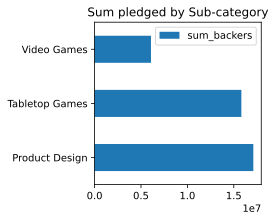

In [34]:
top_pledge_subcat.plot(x="sub_category_name", y="sum_backers", kind="barh", title="Sum pledged by Sub-category", ylabel="Dollars (USD)", xlabel="")


In [35]:
bot_pledge_subcat = pd.read_sql("SELECT SUM(pledged) as sum_backers,sub_category.name as sub_category_name,sub_category.id FROM campaign JOIN currency ON currency.id=currency_id JOIN sub_category ON sub_category_id=sub_category.id JOIN category ON sub_category.category_id=category.id WHERE currency.name='USD' GROUP BY sub_category.id ORDER BY sum_backers ASC LIMIT 3;", conn)



<AxesSubplot:title={'center':'Sum pledged by Sub-category'}>

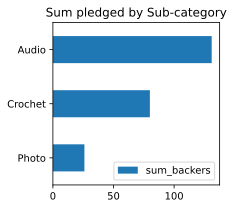

In [36]:
bot_pledge_subcat.plot(x="sub_category_name", y="sum_backers", kind="barh", title="Sum pledged by Sub-category", ylabel="Dollars (USD)", xlabel="")


## What was the amount the most successful board game company raised? How many backers did they have?

In [37]:
cur.execute("SELECT * FROM campaign JOIN currency ON currency.id=currency_id JOIN sub_category ON sub_category_id=sub_category.id JOIN category ON sub_category.category_id=category.id WHERE sub_category.id=14 ORDER BY pledged DESC LIMIT 1;") 
for x in cur: 
    print(x)

(9960, 'Gloomhaven (Second Printing)', 14, 2, 2, datetime.datetime(2017, 4, 4, 0, 0), datetime.datetime(2017, 5, 2, 0, 0), 100000.0, 3999795.77, 40642, 'successful', 2, 'USD', 14, 'Tabletop Games', 7, 7, 'Games')


The most successful board game company was _Gloomhaven (Second Printing)_. They raised **$3,999,795.77** dollars from **40,642** backers.

## Rank the top three countries with the most successful campaigns in terms of dollars (total amount pledged), and in terms of the number of campaigns backed.

In [38]:
countries = pd.read_sql("(SELECT country.name as country,SUM(pledged) as sum_pledged,COUNT(campaign.id) as campaigns,currency.name as currency FROM campaign JOIN sub_category ON sub_category_id=sub_category.id JOIN category ON sub_category.category_id=category.id JOIN country ON country_id=country.id JOIN currency ON currency.id=currency_id GROUP BY country.id ORDER BY sum_pledged DESC LIMIT 3)"
                        " UNION (SELECT country.name as country,SUM(pledged) as sum_pledged,COUNT(campaign.id) as campaigns,currency.name as currency FROM campaign JOIN sub_category ON sub_category_id=sub_category.id JOIN category ON sub_category.category_id=category.id JOIN country ON country_id=country.id JOIN currency ON currency.id=currency_id GROUP BY country.id ORDER BY campaigns DESC LIMIT 3)", conn)

countries = countries.join(pd.DataFrame({'key': ['USD','GBP','CAD'],
                        'multiplier': ['1.0', '1.33', '0.79']})).astype({'multiplier': 'float'})
countries['sum_pledged_usd'] = countries['sum_pledged'].mul(countries['multiplier'])


In [39]:
countries

,country,sum_pledged,campaigns,currency,key,multiplier,sum_pledged_usd
0,US,1.131420e+08,11649,USD,USD,1.00,1.131420e+08
1,GB,9.362976e+06,1304,GBP,GBP,1.33,1.245276e+07
2,CA,2.262536e+06,588,CAD,CAD,0.79,1.787403e+06


<AxesSubplot:title={'center':'Sum pledged by Country (Top 3, log-scale)'}, xlabel='Country', ylabel='Dollars (USD)'>

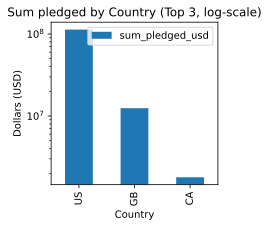

In [40]:
countries.plot(x="country", y="sum_pledged_usd", kind="bar", title="Sum pledged by Country (Top 3, log-scale)", logy=True, ylabel="Dollars (USD)", xlabel="Country")


<AxesSubplot:title={'center':'Top 3 Countries by No. of campaigns'}, xlabel='Country', ylabel='Campaigns'>

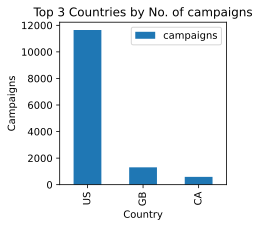

In [41]:
countries.plot(x="country", y="campaigns", kind="bar", title="Top 3 Countries by No. of campaigns", ylabel="Campaigns", xlabel="Country")



## Do longer, or shorter campaigns tend to raise more money? Why?

In [42]:
campaign_length = pd.read_sql("SELECT DATEDIFF(deadline,launched) AS date_difference,AVG(pledged) as sum_pledged,SUM(backers) as backers FROM campaign JOIN currency ON currency_id=currency.id JOIN sub_category ON sub_category_id=sub_category.id JOIN category ON sub_category.category_id=category.id JOIN country ON country_id=country.id WHERE currency.name='USD' GROUP BY date_difference ORDER BY date_difference DESC;", conn)


<AxesSubplot:title={'center':'Average pledged vs Campaign length'}, xlabel='Campaign length (days)', ylabel='Sum pledged'>

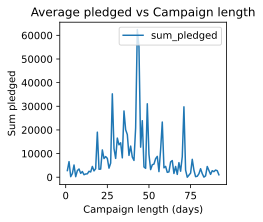

In [43]:
campaign_length.plot(x="date_difference", y="sum_pledged", kind="line", title="Average pledged vs Campaign length", ylabel="Sum pledged", xlabel="Campaign length (days)")



In [44]:
campaign_length = pd.read_sql("SELECT DATEDIFF(deadline,launched) AS date_difference,AVG(backers) as num_backers FROM campaign JOIN sub_category ON sub_category_id=sub_category.id JOIN category ON sub_category.category_id=category.id JOIN country ON country_id=country.id GROUP BY date_difference ORDER BY date_difference DESC;", conn)


<AxesSubplot:title={'center':'Avg. number of backers vs Campaign length'}, xlabel='Campaign length (days)', ylabel='Sum pledged'>

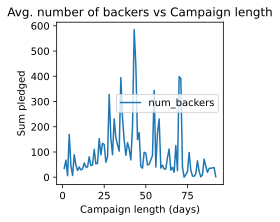

In [45]:
campaign_length.plot(x="date_difference", y="num_backers", kind="line", title="Avg. number of backers vs Campaign length", ylabel="Sum pledged", xlabel="Campaign length (days)")



### There is a bump of backers after 60 days, but they don't contribute much.

In [46]:
campaign_length = pd.read_sql("SELECT DATEDIFF(deadline,launched) AS date_difference,AVG(pledged),AVG(backers),(AVG(pledged)/GREATEST(AVG(backers),1)) as average_pledge_backer FROM campaign JOIN sub_category ON sub_category_id=sub_category.id JOIN category ON sub_category.category_id=category.id JOIN country ON country_id=country.id GROUP BY date_difference ORDER BY date_difference DESC;", conn)


<AxesSubplot:title={'center':'Average pledge by backer vs Campaign length'}, xlabel='Campaign length (days)', ylabel='Average pledge'>

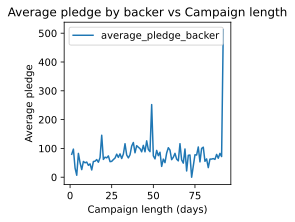

In [47]:
campaign_length.plot(x="date_difference", y="average_pledge_backer", kind="line", title="Average pledge by backer vs Campaign length", ylabel="Average pledge", xlabel="Campaign length (days)")



Clearly, campaign length vs amount pledged is quite normally distributed around a campaign length of 43 days. So short campaigns raise little, but so do longer ones. The sweet spot is in the middle.

# Findings & Recommendations

### What is a realistic Kickstarter campaign goal (in dollars) should the company aim to raise?
A realistic campaign goal in USD is $10,850. This is how much the company should aim to raise if it wants to succeed.

### How many backers will be needed to meet their goal?
There are two ways to think of this. First of all, with an average backing of $75, the company only needs 145 backers at that price. However, the average amount of backers is 901, in which case the company needs only $12 per backer, a far more realistic goal for a board game.

## How many backers can the company realistically expect, based on trends in their category?
It's clear that the vast majority of board game kickstarters have less than 2,000 backers, with the average being 901. The company can probably expect around 900.

# 1. Lower your campaign goal to around $10,850 you will have a higher chance of success.
# 2. Do not set your price per backer over $75, so you will get enough backers.
# 3. Run your campaign for 50 days, not more not less. You will get the most average pledge per backer and therefore the highest total sum pledged.